In [ ]:
# Install PyTorch Geometric and its dependencies
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-$(python -c 'import torch; print(torch.__version__)').html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid # Using Cora for this example

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
class X_ADNET(nn.Module):
    def __init__(self, in_features, hidden_dim, num_layers=2):
        super(X_ADNET, self).__init__()

        # 1. The Encoder (Our "Glass Box" GAT Encoder)
        # We set `return_attention_weights=True` to get the explanations.
        # This is the key to making the model self-interpretable.
        self.gat_layer1 = GATConv(in_features, hidden_dim, heads=1, dropout=0.1)

        # 2. The Decoders (Same as ADNET paper)

        # Structure Decoder: Reconstructs the adjacency matrix (A)
        # We'll use a simple dot product, as implied by H * H.T
        self.structure_decoder = lambda H: torch.sigmoid(torch.mm(H, H.t()))

        # Attribute Decoder: Reconstructs the original node features (X)
        # The paper uses a GCN for this, so we will too.
        self.attribute_decoder = GCNConv(hidden_dim, in_features)

    def forward(self, x, edge_index):
        # --- ENCODER ---
        # Pass data through the GAT encoder
        # We get the embeddings (H) and the attention info (alpha)
        # alpha is a tuple: (edge_index_with_self_loops, attention_scores)
        H, alpha = self.gat_layer1(x, edge_index, return_attention_weights=True)
        H = F.relu(H)

        # Store the attention scores and their corresponding edges
        # This is our "explanation" data
        self.attention_scores = alpha[1]
        self.attention_edges = alpha[0]

        # --- DECODER ---
        # 1. Reconstruct Structure (A_hat)
        A_hat = self.structure_decoder(H)

        # 2. Reconstruct Attributes (X_hat)
        X_hat = self.attribute_decoder(H, edge_index)

        return A_hat, X_hat, H

print("X_ADNET model class defined.")

X_ADNET model class defined.


In [ ]:
# L = (1-alpha) * E_S + alpha * E_A

def adnet_loss(A_hat, A, X_hat, X, alpha_weight=0.5):
    """
    Calculates the combined loss from the ADNET paper (Equation 6)

    A_hat: Reconstructed Adjacency Matrix
    A:     Original Adjacency Matrix
    X_hat: Reconstructed Attribute Matrix
    X:     Original Attribute Matrix
    alpha_weight: The 'a' parameter to balance the two losses
    """

    # 1. Structure Reconstruction Loss (E_S)
    # Using Binary Cross-Entropy (BCE) for the adjacency matrix
    loss_structure = F.binary_cross_entropy(A_hat, A)

    # 2. Attribute Reconstruction Loss (E_A)
    # Using Mean Squared Error (MSE) for the node features
    loss_attribute = F.mse_loss(X_hat, X)

    # 3. Combined Loss (Equation 6)
    loss = (1 - alpha_weight) * loss_structure + alpha_weight * loss_attribute

    return loss, loss_structure, loss_attribute

print("Loss function defined.")

Loss function defined.


In [ ]:
print("Loading data...")
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Pre-processing: Create the full (dense) adjacency matrix 'A'
# The loss function needs this to compare with the reconstructed A_hat
A = torch.zeros(data.num_nodes, data.num_nodes)
A[data.edge_index[0], data.edge_index[1]] = 1

# --- Check Data ---
print(f"Data: {dataset.name}")
print(f"Nodes: {data.num_nodes}")
print(f"Edges: {data.num_edges}")
print(f"Features: {dataset.num_node_features}")
print(f"Dense Adjacency Matrix 'A' created with shape: {A.shape}")

Loading data...


Processing...


Data: Cora
Nodes: 2708
Edges: 10556
Features: 1433
Dense Adjacency Matrix 'A' created with shape: torch.Size([2708, 2708])


Done!


In [ ]:
# Model Hyperparameters
INPUT_FEATURES = dataset.num_node_features
HIDDEN_DIM = 64 # You can tune this
LEARNING_RATE = 0.005
ALPHA_WEIGHT = 0.5 # The 'a' in the loss function (Eq. 6). 0.5 balances them equally.

# Initialize model and optimizer
model = X_ADNET(in_features=INPUT_FEATURES, hidden_dim=HIDDEN_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Model and optimizer initialized.")
print(model)

Model and optimizer initialized.
X_ADNET(
  (gat_layer1): GATConv(1433, 64, heads=1)
  (attribute_decoder): GCNConv(64, 1433)
)


In [ ]:
EPOCHS = 100

print("Starting training...")
model.train() # Set model to training mode

for epoch in range(EPOCHS):
    optimizer.zero_grad()

    # Forward pass: Get reconstructions
    A_hat, X_hat, H = model(data.x, data.edge_index)

    # Calculate loss using the original data (A and data.x)
    loss, loss_s, loss_a = adnet_loss(A_hat, A, X_hat, data.x, alpha_weight=ALPHA_WEIGHT)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1:03d}, Total Loss: {loss:.4f}, '
              f'Struct Loss: {loss_s:.4f}, Attr Loss: {loss_a:.4f}')

print("Training finished.")

Starting training...
Epoch: 010, Total Loss: 0.3527, Struct Loss: 0.6931, Attr Loss: 0.0123
Epoch: 020, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0121
Epoch: 030, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0121
Epoch: 040, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Epoch: 050, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Epoch: 060, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Epoch: 070, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Epoch: 080, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Epoch: 090, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Epoch: 100, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Training finished.


In [ ]:
# Model Hyperparameters
INPUT_FEATURES = dataset.num_node_features
HIDDEN_DIM = 64 # You can tune this
LEARNING_RATE = 0.005
ALPHA_WEIGHT = 0.5 # The 'a' in the loss function (Eq. 6). 0.5 balances them equally.

# Initialize model and optimizer
model = X_ADNET(in_features=INPUT_FEATURES, hidden_dim=HIDDEN_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Model and optimizer initialized.")
print(model)

Model and optimizer initialized.
X_ADNET(
  (gat_layer1): GATConv(1433, 64, heads=1)
  (attribute_decoder): GCNConv(64, 1433)
)


In [ ]:
EPOCHS = 100

print("Starting training...")
model.train() # Set model to training mode

for epoch in range(EPOCHS):
    optimizer.zero_grad()

    # Forward pass: Get reconstructions
    A_hat, X_hat, H = model(data.x, data.edge_index)

    # Calculate loss using the original data (A and data.x)
    loss, loss_s, loss_a = adnet_loss(A_hat, A, X_hat, data.x, alpha_weight=ALPHA_WEIGHT)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1:03d}, Total Loss: {loss:.4f}, '
              f'Struct Loss: {loss_s:.4f}, Attr Loss: {loss_a:.4f}')

print("Training finished.")

Starting training...
Epoch: 010, Total Loss: 0.3527, Struct Loss: 0.6931, Attr Loss: 0.0123
Epoch: 020, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0121
Epoch: 030, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0121
Epoch: 040, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Epoch: 050, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Epoch: 060, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Epoch: 070, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Epoch: 080, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Epoch: 090, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Epoch: 100, Total Loss: 0.3526, Struct Loss: 0.6931, Attr Loss: 0.0120
Training finished.


In [ ]:
print("\n--- Model Evaluation & Anomaly Scoring ---")
model.eval() # Set model to evaluation mode
with torch.no_grad():
    # Get the final reconstructions
    A_hat, X_hat, H = model(data.x, data.edge_index)

    # --- Calculate Per-Node Anomaly Scores ---

    # 1. Attribute Error (per-node)
    # We use sum of squared errors for each node
    error_attr = torch.sum((X_hat - data.x) ** 2, dim=1)

    # 2. Structure Error (per-node)
    # We take the mean BCE loss for each node's row in the adj. matrix
    error_struct = F.binary_cross_entropy(A_hat, A, reduction='none').mean(dim=1)

    # 3. Final Anomaly Score (per-node)
    # This is the implementation of Equation 7 from the paper
    anomaly_scores = (1 - ALPHA_WEIGHT) * error_struct + ALPHA_WEIGHT * error_attr

    # Normalize scores to be between 0 and 1 for easier interpretation
    anomaly_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())

    print(f"Calculated anomaly scores for all {data.num_nodes} nodes.")

    # --- Get the Explanation Data ---
    # These were saved during the forward pass
    attention_edges = model.attention_edges
    attention_scores = model.attention_scores

    print(f"Retrieved {attention_scores.shape[0]} attention scores for {attention_edges.shape[1]} edges.")


--- Model Evaluation & Anomaly Scoring ---
Calculated anomaly scores for all 2708 nodes.
Retrieved 13264 attention scores for 13264 edges.


In [ ]:
print("\n--- Anomaly Explanation: Case Study ---")

# Sort nodes by their anomaly score, descending
top_anomalous_nodes = torch.argsort(anomaly_scores, descending=True)

print("--- Top 5 Most Anomalous Nodes ---")
for i in range(5):
    node_id = top_anomalous_nodes[i].item()
    print(f"Rank {i+1}: Node ID {node_id} (Normalized Score: {anomaly_scores[node_id]:.4f})")

# ---
# Generate the "Explanation Report" for the #1 ranked anomaly
# ---
target_node = top_anomalous_nodes[0].item()

print(f"\n--- EXPLAINING ANOMALY: Node {target_node} ---")

# The GAT attention_edges[1] lists the target nodes for each edge.
# We find all attention scores for edges pointing *to* our target node.
is_target = (attention_edges[1] == target_node)
target_edge_indices = torch.where(is_target)[0]

print(f"Node {target_node} has {len(target_edge_indices)} neighbors (incl. self-loop).")
print("This node's embedding was built by paying attention to:")

# Collect and sort the attention scores for this node
explanations = []
for edge_idx in target_edge_indices:
    # attention_edges[0] is the source node (the neighbor)
    neighbor_id = attention_edges[0][edge_idx].item()
    # attention_scores contains the alpha value for that edge
    score = attention_scores[edge_idx].item()
    explanations.append((neighbor_id, score))

# Sort by attention score, descending
explanations.sort(key=lambda x: x[1], reverse=True)

print("\n--- Top 5 Most Influential Neighbors (The 'Evidence') ---")
for neighbor, score in explanations[:5]:
    if neighbor == target_node:
        print(f"  - Paid {score:.3f} attention to ITSELF (self-loop).")
    else:
        print(f"  - Paid {score:.3f} attention to neighbor Node {neighbor}.")

print("\nThis 'Attention Map' is the explanation for why the model flagged this node.")


--- Anomaly Explanation: Case Study ---
--- Top 5 Most Anomalous Nodes ---
Rank 1: Node ID 677 (Normalized Score: 1.0000)
Rank 2: Node ID 442 (Normalized Score: 0.8966)
Rank 3: Node ID 921 (Normalized Score: 0.8754)
Rank 4: Node ID 1794 (Normalized Score: 0.8723)
Rank 5: Node ID 2308 (Normalized Score: 0.8701)

--- EXPLAINING ANOMALY: Node 677 ---
Node 677 has 2 neighbors (incl. self-loop).
This node's embedding was built by paying attention to:

--- Top 5 Most Influential Neighbors (The 'Evidence') ---
  - Paid 0.509 attention to neighbor Node 954.
  - Paid 0.491 attention to ITSELF (self-loop).

This 'Attention Map' is the explanation for why the model flagged this node.


Created visualization graph with 2 nodes and 2 edges.
Drawing explanation graph...


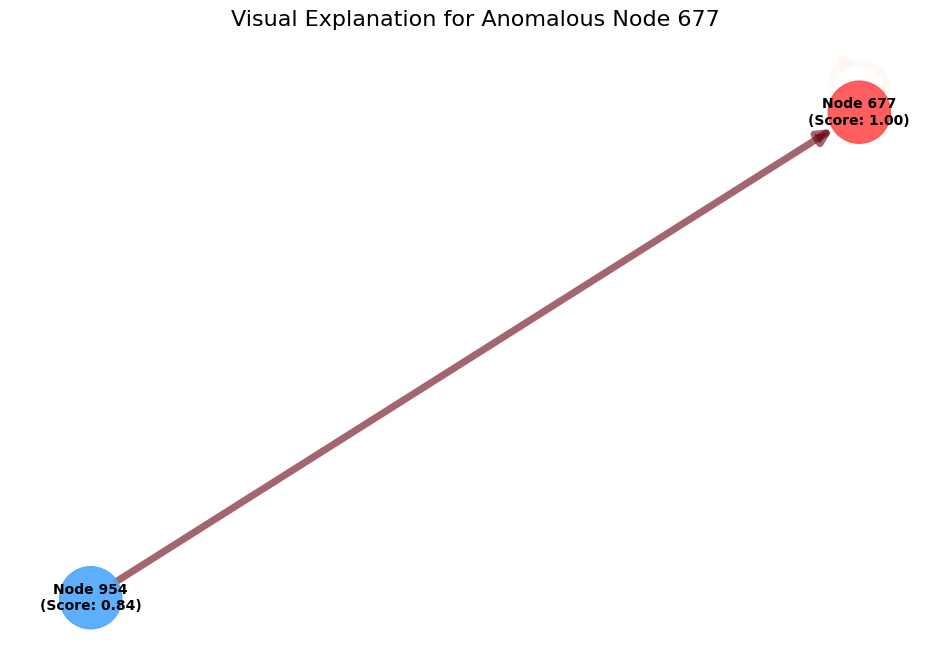

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. PREPARE DATA FOR VISUALIZATION ---

# We will build a small, directed "ego graph" for the target node
# G = nx.DiGraph() # DiGraph = Directed Graph

# Use the variables from the previous cell (Cell 9)
# target_node = top_anomalous_nodes[0].item()
# explanations = ...
# anomaly_scores = ...

# Create a new directed graph
G = nx.DiGraph()

# Add all the nodes and edges from our explanation
# The edge goes from the "neighbor" to the "target"
# We store the attention score as an attribute of the edge
for neighbor, score in explanations:
    G.add_node(neighbor, anomaly_score=anomaly_scores[neighbor].item())
    G.add_node(target_node, anomaly_score=anomaly_scores[target_node].item())

    # Add the directed edge and store its attention score
    G.add_edge(neighbor, target_node, attention=score)

print(f"Created visualization graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# --- 2. SET UP PLOTTING STYLES ---

# Get a good layout for the graph
pos = nx.spring_layout(G, k=0.8, iterations=50)

# Create a list of node colors: red for the anomaly, blue for neighbors
node_colors = []
for node in G.nodes():
    if node == target_node:
        node_colors.append('#ff4d4d') # Red
    else:
        node_colors.append('#4da6ff') # Light Blue

# Create a list of edge widths based on attention
# Multiply by 10 to make the differences visible
edge_widths = [d['attention'] * 10.0 for u, v, d in G.edges(data=True)]

# Create a list of edge colors for a heatmap effect
edge_colors = [d['attention'] for u, v, d in G.edges(data=True)]

# Create labels to show node ID and anomaly score
labels = {}
for node, data in G.nodes(data=True):
    labels[node] = f"Node {node}\n(Score: {data['anomaly_score']:.2f})"

# --- 3. DRAW THE GRAPH ---

print("Drawing explanation graph...")
plt.figure(figsize=(12, 8))

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors, alpha=0.9)

# Draw the edges
nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Reds, # Use a Red heatmap for attention
    alpha=0.6,
    arrows=True,
    arrowsize=20,
    node_size=2000
)

# Draw the labels
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight='bold')

plt.title(f"Visual Explanation for Anomalous Node {target_node}", fontsize=16)
plt.axis('off') # Turn off the X/Y axis
plt.show()

In [ ]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00


In [ ]:
from pyvis.network import Network
import matplotlib.cm as cm
import matplotlib.colors as colors

def visualize_explanation(target_node_id, file_name="explanation.html"):
    """
    Creates a beautiful, interactive pyvis visualization for a
    given node's attention-based explanation.
    """

    print(f"--- Visualizing Explanation for Node {target_node_id} ---")

    # 1. GATHER DATA FOR THIS NODE

    # Find all attention scores for edges pointing *to* our target node
    is_target = (attention_edges[1] == target_node_id)
    target_edge_indices = torch.where(is_target)[0]

    if len(target_edge_indices) == 0:
        print(f"Node {target_node_id} has no incoming attention edges to visualize.")
        return

    # Collect explanations
    explanations = []
    for edge_idx in target_edge_indices:
        neighbor_id = attention_edges[0][edge_idx].item()
        score = attention_scores[edge_idx].item()
        explanations.append((neighbor_id, score))

    # 2. SETUP THE PYVIS NETWORK

    # Create a pyvis network object
    # `notebook=True` is critical for Colab
    net = Network(notebook=True, directed=True, cdn_resources='in_line')

    # Get a colormap for attention scores (Reds)
    norm = colors.Normalize(vmin=min(s[1] for s in explanations), vmax=max(s[1] for s in explanations))
    cmap = cm.Reds

    # 3. ADD NODES

    # Add the Target Node (Anomalous)
    target_score = anomaly_scores[target_node_id].item()
    net.add_node(
        target_node_id,
        label=f"Node {target_node_id}",
        title=f"Anomaly Score: {target_score:.3f}", # Hover text
        color="#f03a3e", # Red
        size=30,
        shape="dot"
    )

    # Add all Neighbor Nodes
    for neighbor_id, score in explanations:
        if neighbor_id == target_node_id:
            continue # Self-loop is handled by the edge

        neighbor_score = anomaly_scores[neighbor_id].item()

        net.add_node(
            neighbor_id,
            label=f"Node {neighbor_id}",
            title=f"Anomaly Score: {neighbor_score:.3f}",
            color="#26a69a", # Greenish/Teal
            size=15,
            shape="dot"
        )

    # 4. ADD EDGES (The Explanation)

    for neighbor_id, score in explanations:
        # Scale width to be visible
        width = score * 15.0

        # Get color from the heatmap
        edge_color = colors.to_hex(cmap(norm(score)))

        net.add_edge(
            neighbor_id,
            target_node_id,
            width=width,
            title=f"Attention: {score:.3f}", # Hover text
            color=edge_color
        )

    # 5. SHOW THE GRAPH

    net.set_options("""
    var options = {
      "physics": {
        "barnesHut": {
          "gravitationalConstant": -2000,
          "centralGravity": 0.1,
          "springLength": 100
        },
        "minVelocity": 0.75
      }
    }
    """)
    net.show(file_name)
    print(f"Visualization saved to {file_name}")
    print(f"Displaying graph for Node {target_node_id} below...")

In [ ]:
# 1. Get the ID of a "normal" node
# We'll pick the 1000th node from the sorted list
normal_node_id = top_anomalous_nodes[1000].item()

# 2. Visualize it
visualize_explanation(normal_node_id, file_name="2_NORMAL_explanation.html")

--- Visualizing Explanation for Node 288 ---
2_NORMAL_explanation.html
Visualization saved to 2_NORMAL_explanation.html
Displaying graph for Node 288 below...
